In [1]:
# Uncomment if needed

!python -m pip install tensorflow opencv-python numpy pandas matplotlib scikit-learn


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
print(sys.executable)

c:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe


In [3]:
!python -m pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
dataset_path = "UTKFace_small" 

In [6]:
def age_to_group(age):
    if age < 13:
        return 0  # Child
    elif age < 20:
        return 1  # Teen
    elif age < 40:
        return 2  # Adult
    elif age < 60:
        return 3  # Middle
    else:
        return 4  # Senior

In [7]:
images = []
ages = []
genders = []
ethnicities = []

for file in os.listdir(dataset_path):
    try:
        parts = file.split("_")
        age = int(parts[0])
        gender = int(parts[1])
        ethnicity = int(parts[2])

        img_path = os.path.join(dataset_path, file)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, (96,96))
        img = img / 255.0

        images.append(img)
        ages.append(age_to_group(age))
        genders.append(gender)
        ethnicities.append(ethnicity)

    except:
        continue

X = np.array(images)
y_age = np.array(ages)
y_gender = np.array(genders)
y_ethnicity = np.array(ethnicities)

print("Dataset loaded successfully")
print("Images shape:", X.shape)

Dataset loaded successfully
Images shape: (4900, 96, 96, 3)


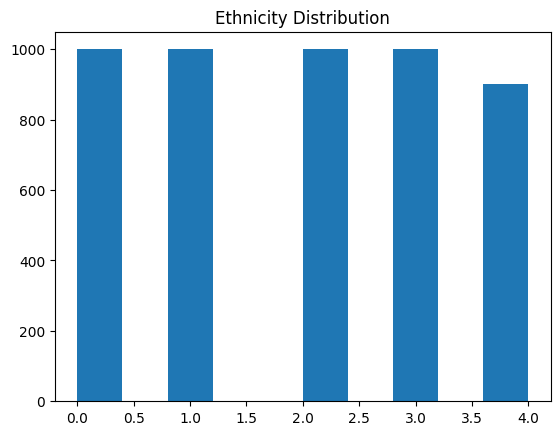

In [8]:
plt.hist(y_ethnicity)
plt.title("Ethnicity Distribution")
plt.show()

In [9]:
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_eth_train, y_eth_test = train_test_split(
    X, y_age, y_gender, y_ethnicity,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (3920, 96, 96, 3)
Test shape: (980, 96, 96, 3)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

In [11]:
!python -m pip install keras


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

In [17]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(96,96,3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(5, activation='softmax', name='age')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

model = Model(inputs, [gender_output, age_output, ethnicity_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [19]:
history = model.fit(
    X_train,
    {
        'gender': y_gender_train,
        'age': y_age_train,
        'ethnicity': y_eth_train
    },
    epochs=15,
    batch_size=32,
    validation_data=(
        X_test,
        {
            'gender': y_gender_test,
            'age': y_age_test,
            'ethnicity': y_eth_test
        }
    ),
    callbacks=[early_stop]
)

Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - age_accuracy: 0.7355 - age_loss: 0.8249 - ethnicity_accuracy: 0.2819 - ethnicity_loss: 2.0492 - gender_accuracy: 0.6048 - gender_loss: 0.7817 - loss: 3.6473 - val_age_accuracy: 0.7908 - val_age_loss: 0.5980 - val_ethnicity_accuracy: 0.3878 - val_ethnicity_loss: 1.4424 - val_gender_accuracy: 0.6898 - val_gender_loss: 0.5966 - val_loss: 2.6316
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 49s 399ms/step - age_accuracy: 0.7939 - age_loss: 0.6259 - ethnicity_accuracy: 0.3735 - ethnicity_loss: 1.6055 - gender_accuracy: 0.6801 - gender_loss: 0.6345 - loss: 2.8667 - val_age_accuracy: 0.8122 - val_age_loss: 0.5712 - val_ethnicity_accuracy: 0.4408 - val_ethnicity_loss: 1.3543 - val_gender_accuracy: 0.7500 - val_gender_loss: 0.5169 - val_loss: 2.4362
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - age_accuracy: 0.8117 - age_loss: 0.5528 - ethnicity_accuracy: 0.4140 - ethnicity_loss: 1.4885 - gender_accuracy: 0.7059 - gender_loss: 0.5811

In [20]:
model.evaluate(
    X_test,
    {
        'gender': y_gender_test,
        'age': y_age_test,
        'ethnicity': y_eth_test
    }
)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - age_accuracy: 0.8122 - age_loss: 0.5044 - ethnicity_accuracy: 0.4847 - ethnicity_loss: 1.2540 - gender_accuracy: 0.7898 - gender_loss: 0.4674 - loss: 2.2221


[2.222059488296509,
 0.46742433309555054,
 0.504408597946167,
 1.2540181875228882,
 0.8122448921203613,
 0.48469388484954834,
 0.7897959351539612]

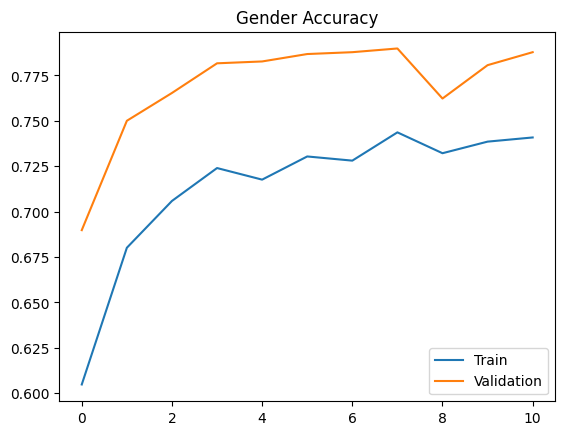

In [27]:
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title("Gender Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

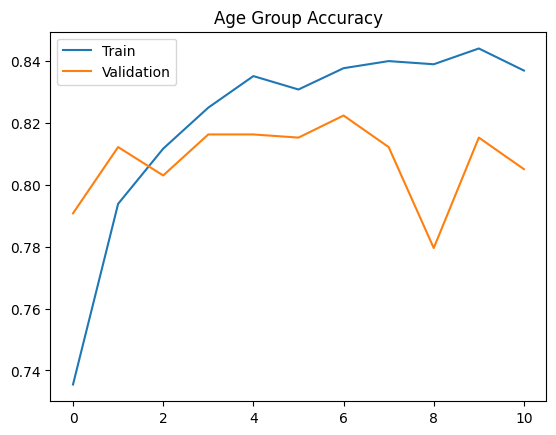

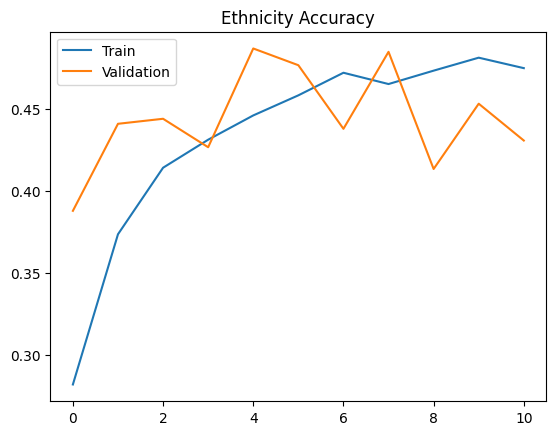

In [28]:
plt.plot(history.history['age_accuracy'])
plt.plot(history.history['val_age_accuracy'])
plt.title("Age Group Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history['ethnicity_accuracy'])
plt.plot(history.history['val_ethnicity_accuracy'])
plt.title("Ethnicity Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

In [24]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [25]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [26]:
history_finetune = model.fit(
    X_train,
    {
        'gender': y_gender_train,
        'age': y_age_train,
        'ethnicity': y_eth_train
    },
    epochs=5,
    batch_size=32,
    validation_data=(
        X_test,
        {
            'gender': y_gender_test,
            'age': y_age_test,
            'ethnicity': y_eth_test
        }
    )
)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 504ms/step - age_accuracy: 0.7839 - age_loss: 0.6687 - ethnicity_accuracy: 0.3487 - ethnicity_loss: 2.0671 - gender_accuracy: 0.6255 - gender_loss: 0.8476 - loss: 3.5874 - val_age_accuracy: 0.8133 - val_age_loss: 0.5061 - val_ethnicity_accuracy: 0.4735 - val_ethnicity_loss: 1.2921 - val_gender_accuracy: 0.7735 - val_gender_loss: 0.4587 - val_loss: 2.2514
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - age_accuracy: 0.7824 - age_loss: 0.6622 - ethnicity_accuracy: 0.3768 - ethnicity_loss: 1.8498 - gender_accuracy: 0.6686 - gender_loss: 0.7305 - loss: 3.2444 - val_age_accuracy: 0.8071 - val_age_loss: 0.5062 - val_ethnicity_accuracy: 0.4684 - val_ethnicity_loss: 1.3101 - val_gender_accuracy: 0.7684 - val_gender_loss: 0.4684 - val_loss: 2.2791
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 85s 476ms/step - age_accuracy: 0.7964 - age_loss: 0.6318 - ethnicity_accuracy: 0.4138 - ethnicity_loss: 1.6885 - gender_accuracy: 0.6760 - gender_loss: 0.6828 - 

In [29]:
model.save("face_multi_output_model.keras")

In [30]:
model.save("face_multi_output_model.h5")
print("Model Saved Successfully")

Model Saved Successfully
